## Imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

### Parameters:

In [3]:
h_bar**2/2/m_0

3.8097342613975337e-32

In [9]:
# ---- constants ----
# all in electronovolts
h = 4.135667696e-15
h_bar = 6.582119569e-16 #eV*s
m_0 = 5.686e-12 #eV*s/A^2
J_to_eV = 1
alpha_f = 1/137.036

# # all in Si
# h = 6.626e-34
# h_bar = 1.054571e-34
# m_0 = 9.109383e-31

eV_to_J = 1.602176e-19
J_to_eV = 1/eV_to_J
h_bar2_2m = 3.81e-20 #ev*Angstr.^2

# ---- material parameters ----
# GaAs
# Define the material parameters
a_lc = 5.65325e-10
E_g = 1.519 # Bandgap energy
E_p = 25.6#*eV_to_J
#P_cv = h_bar*np.sqrt(E_p/(2*m_0)) # zmienić na formułę z h_bar2_2m
P_cv = np.sqrt(E_p*h_bar2_2m)

F = -1.94
delta_so = 0.341

# optical parameters:
epsilon_r = 13.49
n_r = np.sqrt(epsilon_r)

# Define the spin-orbit coupling constants
gamma_1 = 6.98
gamma_2 = 2.06
gamma_3 = 2.93

In [23]:
P_cv

9.876031591687017e-10

### Abs coeff:

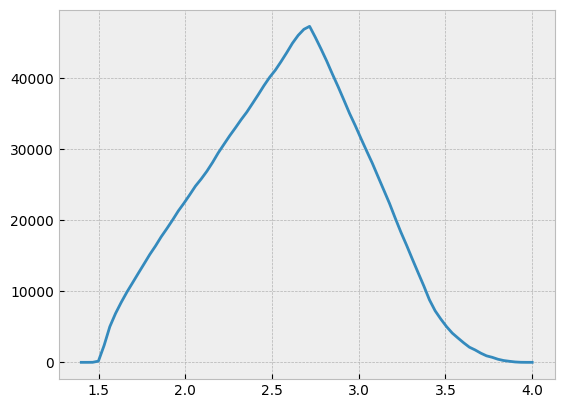

In [22]:
def calc_absorption_coeff(hw):
    """k needs to be in angstrems

    Args:
        k (_type_): _description_

    Returns:
        _type_: _description_
    """
    def norm_sec(x, del_l=0.01):
        y = 1/(np.pi*del_l*np.cosh(x/del_l))

        return y
    
    def integrand(kx, ky, kz, hw):
        # Define the 8x8 Hamiltonian matrix
        H = np.zeros((4,4), dtype=np.complex128)
        
        # with conversion of values from p. 189 
        # file:///D:/Nauka/in%C5%BCynierka/bands-and-photons-in-iii-
        # v-semiconductor-quantum-structures-0198767277-9780198767275_compress.pdf
        
        # Fill in the off-diagonal elements of the Hamiltonian
        inter = (h_bar/m_0*P_cv*1e1)**2
        inter += (h_bar/m_0*P_cv*1e1)**2
        inter += (h_bar/m_0*P_cv*1e1)**2
        
        E_ck = E_g/2+np.sqrt(E_g**2/4+h_bar2_2m*2/3*E_p*np.dot([kx, ky, kz],[kx, ky, kz]))
        E_vk = 0
        inter = inter*hw/(E_ck-E_vk)**2*norm_sec(E_ck-E_vk-hw)
        
        return inter

    k_top = 0.2*2*np.pi/a_lc#/1e10
    #I, err = integrate.tplquad(integrand, 0., k_top, 0., k_top, 0., k_top, args=([hw]))
    
    n_bins = 40
    dk = k_top/n_bins

    k_bins = np.linspace(0, k_top, n_bins+1)
    k_vals = (k_bins[:-1]+k_bins[1:])/2
    I = 0.
    for x_i in range(n_bins):
        for y_i in range(n_bins):
            for z_i in range(n_bins):
                I+=integrand(k_vals[x_i],
                          k_vals[y_i],
                          k_vals[z_i],
                          hw)
    I = I*dk**3
    
    alpha = alpha_f/(2*np.pi*n_r)*I
    
    return alpha


points = 50
alphas = np.zeros((points))
hw_range = np.linspace(1.4,
                       2.0,
                       points)
for i, hw in enumerate(hw_range):
    alphas[i] = calc_absorption_coeff(hw)


alphas = alphas*10000
with plt.style.context('bmh'):
    plt.plot(hw_range, alphas)

### Abs coeff with strains:

In [ ]:
# ---- constants ----
# all in electronovolts
h = 4.135667696e-15
h_bar = 6.582119569e-16 #eV*s
m_0 = 5.686e-12 #eV*s/A^2
J_to_eV = 1
alpha_f = 1/137.036

# # all in Si
# h = 6.626e-34
# h_bar = 1.054571e-34
# m_0 = 9.109383e-31

eV_to_J = 1.602176e-19
J_to_eV = 1/eV_to_J
h_bar2_2m = 3.81e-20 #ev*Angstr.^2

# ---- material parameters ----
# GaAs
# Define the material parameters
a_lc = 5.65325e-10
E_g = 1.519 # Bandgap energy
E_p = 25.6#*eV_to_J
#P_cv = h_bar*np.sqrt(E_p/(2*m_0)) # zmienić na formułę z h_bar2_2m
P_cv = np.sqrt(E_p*h_bar2_2m)

F = -1.94
delta_so = 0.341

# optical parameters:
epsilon_r = 13.49
n_r = np.sqrt(epsilon_r)

# Define the spin-orbit coupling constants
gamma_1 = 6.98
gamma_2 = 2.06
gamma_3 = 2.93